In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# AlexNet

It was the first convolutional model that was successfully trained on Imagenet, a dataset with 1M training images of 1000 classes.

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes=10)
inp = torch.rand(1,3,128,128)
print(model(inp).shape)

torch.Size([1, 10])


# VGG

The famous paper “Very Deep Convolutional Networks for Large-Scale Image Recognition” made the term “deep” viral. It was the first study that provided undeniable evidence that simply adding more layers increases performance. Nonetheless, this assumption holds true up to a certain point.

The main principle is that a stack of three 3×3 conv layers are similar to a single 7×7
layer. And maybe even better because they use three non-linear activations in between (instead of one), which makes the function more discriminative.

Secondly, this design decreases the number of parameters. Intuitively, it can be regarded as a regularisation on the 7×7 conv. filters, constricting them to have a 3x3 non-linear decomposition.

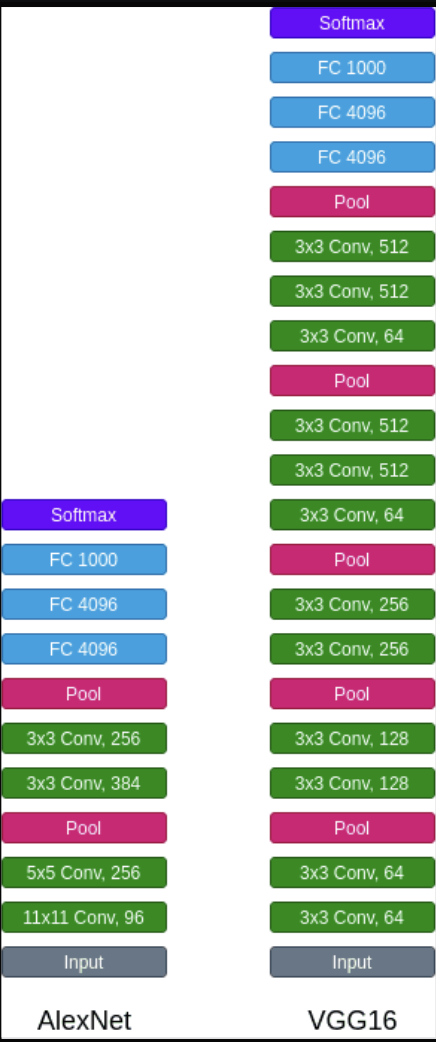

# InceptionNet/GoogleNet

Motivation: Increasing the depth (number of layers) is not the only way to make a model bigger. What about increasing both the depth and width of the network while keeping computations to a constant level?

With 1×1 convolutions! The main purpose is dimension reduction by reducing the output channels of each convolution block. Then we can process the input with different kernel sizes. As long as the output is padded, it is the same as in the input.

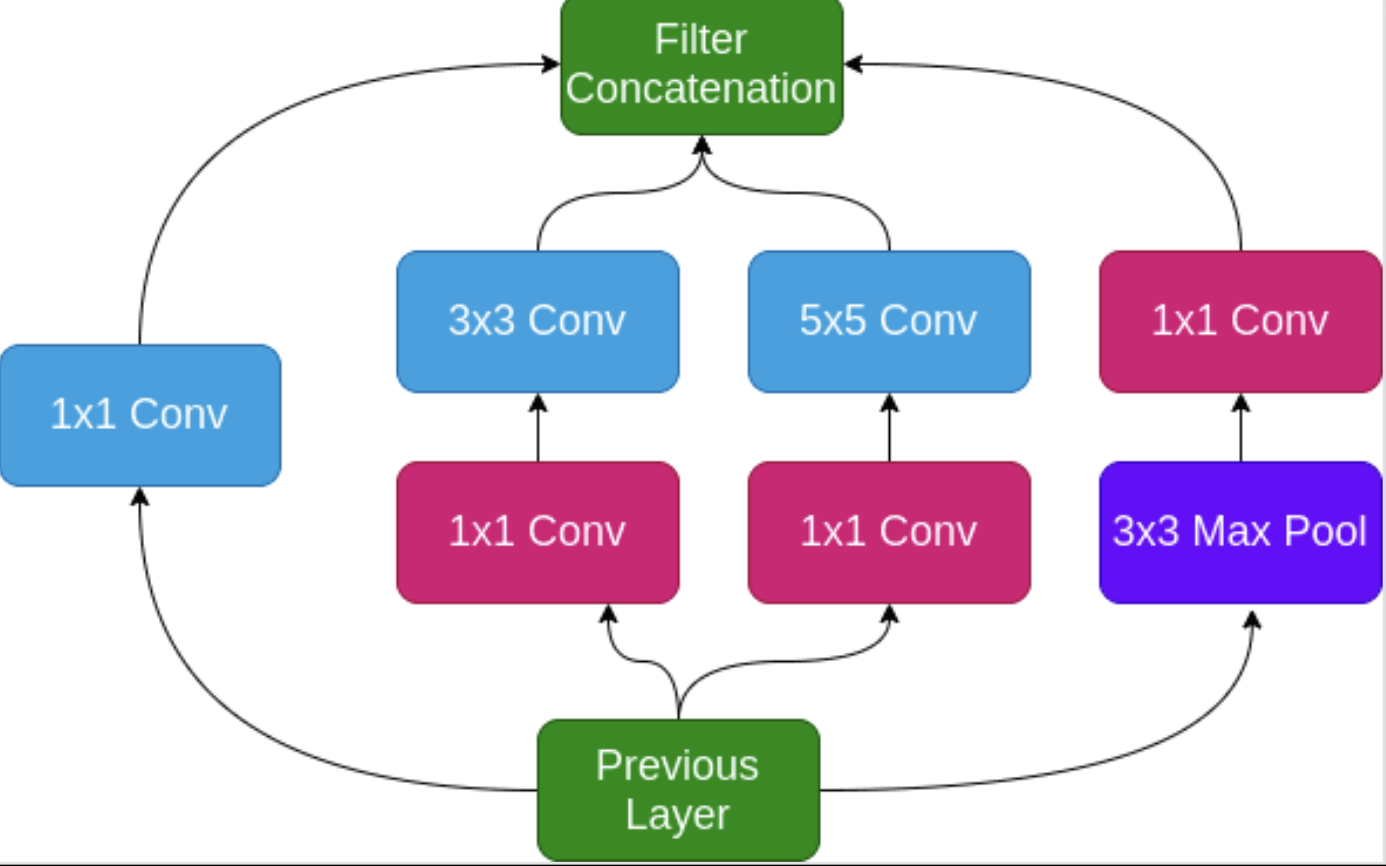

the authors claim that they try to approximate a sparse convnet with normal dense layers (as shown in the figure).

Why? Because they believe that only a small number of neurons are effective.

Moreover, it uses convolutions of different kernel sizes (5×5,3×3,1×1) to capture details at multiple scales.

In general, a larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.

Besides, 1×1 convolutions are used to compute reductions before the computationally expensive convolutions (3×3 and 5×5).

The InceptionNet/GoogleNet architecture consists of 9 inception modules stacked together, with max-pooling layers in between (to halve the spatial dimensions). It consists of 22 layers (27 with the pooling layers). It uses global average pooling after the last inception module.



In [3]:
import torch
import torch.nn as nn

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        relu = nn.ReLU()
        self.branch1 = nn.Sequential(
                  nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                  relu)

        conv3_1 = nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        conv3_3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.branch2 = nn.Sequential(conv3_1, conv3_3,relu)

        conv5_1 = nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        conv5_5 = nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=2)
        self.branch3 = nn.Sequential(conv5_1,conv5_5,relu)

        max_pool_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        conv_max_1 = nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.branch4 = nn.Sequential(max_pool_1, conv_max_1,relu)

    def forward(self, input):
        output1 = self.branch1(input)
        output2 = self.branch2(input)
        output3 = self.branch3(input)
        output4 = self.branch4(input)
        return torch.cat([output1, output2, output3, output4], dim=1)

model = InceptionModule(in_channels=3,out_channels=32)
inp = torch.rand(1,3,128,128)
print(model(inp).shape)

torch.Size([1, 128, 128, 128])


Each dot-product operation gives a notion of similarity. (TRUE ✅)
The operation performed by the kernel is an element-wise multiplication followed by a summation. When vectors (or flattened patches/kernels) are multiplied this way, the resulting scalar value is mathematically a dot product (or technically, a correlation). A dot product measures the similarity between two vectors. A high output value indicates that the image patch and the kernel have a high degree of correlation (the feature the kernel is looking for is present).